In [71]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Sequential, Model
from keras.models import model_from_json
from tensorflow import keras
from keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.compat.v1
from tensorflow.keras.losses import MeanSquaredError
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/anjalichauhan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [72]:
## USE: full log(returns)/returns dataframe
## Risk Adjusted Returns

df = pd.read_pickle("../Data/risk_adj_returns.pkl").iloc[1:]
df1 = pd.read_pickle("../Data/returns.pkl").iloc[1:]

drop_columns = []
for col in df1.columns:
    if df1[col].isnull().all() == True:
        drop_columns.append(col)
        
df1.drop(columns=drop_columns, inplace=True)

# df['pct_change'] = df.close.pct_change()
# df['log_ret'] = np.log(df.close) - np.log(df.close.shift(1))
# df = df.dropna()

In [73]:
#df = df.dropna(how='any',axis=0) #All rows have NaN

In [74]:
df1.tail()

,905270,921795,904261,905261,916328,923024,936365,902355,912215,929813,...,9660J1,69568X,543755,77463M,29235J,131745,69487D,68157P,9110RA,292703
date,,,,,,,,,,,,,,,,,,,,,
2021-05-24,NaN,NaN,NaN,NaN,0.136600,NaN,0.349877,NaN,NaN,NaN,...,0.376702,4.400221,1.590198,-0.991004,1.682900,3.364703,2.271817,0.634962,4.859794,1.204016
2021-05-25,NaN,NaN,NaN,NaN,0.946372,NaN,0.542355,NaN,NaN,NaN,...,0.230947,-0.288569,0.449063,-1.661106,0.439588,-0.548765,0.185928,0.727530,1.884279,-0.498203
2021-05-26,NaN,NaN,NaN,NaN,-1.393581,NaN,0.616491,NaN,NaN,NaN,...,1.296083,2.388001,-0.166049,3.255613,2.317760,4.702784,0.673960,2.336242,-0.429666,-1.520393
2021-05-27,NaN,NaN,NaN,NaN,-0.907923,NaN,0.102119,NaN,NaN,NaN,...,0.056867,1.893011,-0.063971,-0.510347,1.044185,-0.275482,1.979237,1.876893,1.247655,2.369727
2021-05-28,NaN,NaN,NaN,NaN,0.829804,NaN,2.116807,NaN,NaN,NaN,...,-0.312589,-0.892462,-0.409679,0.519992,0.160551,-1.549363,0.570831,0.766354,-0.444733,1.742926


In [75]:
def get_investable(t, n_rows):
    "Find stocks in investable universe at time t\
    (stocks in the S&P500 that have prices recorded for the last n_rows days)"
    
    df_investable = df1.copy(deep = True).sort_index(ascending = False)
    
    #add 1 date to get the test features in investable
    t = t + pd.DateOffset(1)
    
    #if t is now a non-trading day, advance until we reach a valid trading day
    while t not in df_investable.index:
        t = t + pd.DateOffset(1)
    
    t_index = df_investable.index.get_loc(t)
    
    #take n_rows worth of data upto time specified
    df_investable = df_investable.iloc[t_index + 1:t_index + n_rows + 1]
    
    #find all stocks that exist in the S&P at this time period
    investable_universe = []
    for col in df_investable.columns:
        if ~df_investable[col].iloc[:n_rows].isna().any():
            investable_universe.append(col)
        
    df_investable = df_investable[investable_universe]
    
    return df_investable

In [76]:
df1 = get_investable(pd.to_datetime('2018-05-11'),500)
df1.head()

,916328,936365,905271,905113,905802,905425,906156,916305,992816,921093,...,311917,69568X,543755,77463M,29235J,131745,69487D,68157P,9110RA,292703
date,,,,,,,,,,,,,,,,,,,,,
2018-05-11,1.155878,-1.483924,0.422731,0.440871,-0.916272,0.208893,0.039456,0.189573,-0.762997,0.182232,...,0.910010,-1.298276,0.524017,-2.303263,-1.639854,0.687071,-0.282002,1.212495,-2.540416,0.918045
2018-05-10,1.952862,1.506276,0.424525,0.665344,1.523657,1.131734,0.875622,-0.132526,1.430401,0.457666,...,-0.047163,-0.596383,1.208014,11.324786,1.981454,1.009464,0.658962,0.433437,2.485207,-0.570505
2018-05-09,1.175268,2.928510,0.843985,1.236468,2.364144,-1.457249,0.761981,-0.489827,0.704112,-0.568828,...,3.119572,1.616055,-3.125446,4.231626,1.659818,-0.220334,-0.151837,1.978531,-0.236128,0.219173
2018-05-08,-1.028321,0.172563,0.036708,1.366291,2.853766,-2.224484,1.176709,-0.375375,0.480665,0.595102,...,0.146117,-0.264227,-1.725105,-2.178649,0.218023,2.915452,0.335161,1.020625,0.474496,-0.398633
2018-05-07,0.987402,2.748227,0.423937,1.974362,0.868677,-0.879089,0.233859,0.832702,0.723495,-0.387597,...,0.328098,2.951477,2.178275,6.744186,-0.024219,0.652103,-1.814918,2.172496,-0.823529,-0.538091


In [77]:
tts = train_test_split(df1, test_size=0.2, shuffle=False)
train = tts[0]
test = tts[1]

In [78]:
train.tail()

,916328,936365,905271,905113,905802,905425,906156,916305,992816,921093,...,311917,69568X,543755,77463M,29235J,131745,69487D,68157P,9110RA,292703
date,,,,,,,,,,,,,,,,,,,,,
2016-10-14,-0.463641,4.006163,0.294874,-1.158691,0.349379,-0.367823,-0.430392,0.453096,0.555651,-0.284024,...,0.409130,-1.862765,0.351865,3.636364,0.351105,-1.812908,-0.432050,0.223839,-1.865672,-0.444939
2016-10-13,0.000000,-1.963746,-0.414125,-1.328181,-0.846805,0.854839,-0.461361,-1.406353,-0.306801,-0.330267,...,-0.684346,-0.630242,0.708717,0.917431,-1.549097,-3.092059,-0.875998,-0.334635,-3.249097,0.272648
2016-10-12,-0.437318,1.846154,0.120618,-2.865819,-1.160358,1.075970,-0.279330,0.968927,0.894239,0.118092,...,0.699903,0.704648,0.248668,1.869159,-1.276542,-1.454294,0.794663,0.223589,-0.359712,-1.139427
2016-10-11,-5.379310,-4.970760,-2.031019,-11.425005,-2.557924,-1.398489,-1.680129,-0.959629,0.215424,-2.149295,...,-2.314084,-0.422991,-1.573427,0.943396,-1.702075,-0.413793,-0.875231,-0.666297,-2.797203,-2.228079
2016-10-10,1.233419,1.333333,0.236897,0.446035,1.658187,0.679722,0.226684,0.632701,1.744696,1.453693,...,0.084219,2.207416,0.456621,-8.620690,0.274075,1.045296,-0.155355,-0.524717,1.490419,0.529865


In [79]:
test.tail()

,916328,936365,905271,905113,905802,905425,906156,916305,992816,921093,...,311917,69568X,543755,77463M,29235J,131745,69487D,68157P,9110RA,292703
date,,,,,,,,,,,,,,,,,,,,,
2016-05-24,1.632325,3.960396,1.150612,1.508398,-0.665643,1.080222,2.012895,1.405975,1.524422,3.981207,...,2.560616,0.781611,2.232519,-2.020202,2.325226,2.200825,2.945144,2.523060,3.903904,1.088886
2016-05-23,-0.611702,4.392765,0.162586,1.865755,1.612903,-1.332288,-0.516270,-0.122872,1.270741,1.531509,...,0.045341,-1.843109,0.211060,7.027027,1.949470,-0.068729,0.644869,2.360455,-2.489019,-0.118217
2016-05-20,0.966702,2.652520,-0.183509,-0.109406,0.698568,-0.078309,1.880778,1.082328,1.082803,3.805056,...,0.569995,2.355838,0.980392,0.543478,3.219575,0.000000,2.267731,2.768265,-0.582242,1.075397
2016-05-19,-1.350993,-1.822917,0.000000,1.108760,-1.207729,0.868878,-1.227960,-0.617175,-0.380711,2.292722,...,0.079863,1.913151,-0.339847,-0.540541,-1.412474,-2.348993,-0.689417,-1.072840,-1.079914,-0.274071
2016-05-18,0.106073,1.319261,-0.825861,-3.010928,0.520291,-1.875678,1.210962,2.364621,1.144507,0.053348,...,-0.034215,3.180885,-0.211954,3.351955,1.481720,-0.996678,2.690265,0.084770,3.889304,0.226920


In [89]:
# Feature Scaling
#sc = MinMaxScaler(feature_range = (0, 1))
sc = RobustScaler()
training_set_scaled = sc.fit_transform(train)
test_set_scaled = sc.fit_transform(test)
pd.DataFrame(training_set_scaled).head()

,0,1,2,3,4,5,6,7,8,9,...,634,635,636,637,638,639,640,641,642,643
0,0.842067,-0.468773,0.404353,0.118464,-0.425928,0.092497,-0.064301,0.144417,-0.714462,0.126731,...,0.614245,-0.484637,0.368224,-0.399867,-1.052158,0.269567,-0.573198,0.677218,-1.092573,0.617811
1,1.468998,0.380586,0.406242,0.224872,0.491904,0.949305,0.812800,-0.150454,1.163182,0.345201,...,-0.083221,-0.238051,0.871468,1.949033,0.999471,0.428966,1.224594,0.208939,0.879282,-0.528743
2,0.857320,0.784568,0.847777,0.495604,0.808071,-1.454426,0.693596,-0.477552,0.541447,-0.468999,...,2.224294,0.539214,-2.316831,0.726472,0.817251,-0.179074,-0.324506,1.137670,-0.188462,0.079505
3,-0.876089,0.001748,-0.001984,0.557145,0.992253,-2.166761,1.128628,-0.372775,0.350167,0.454213,...,0.057617,-0.121359,-1.286544,-0.378389,0.000411,1.371330,0.605946,0.561889,0.090359,-0.396359
4,0.709539,0.733359,0.405623,0.845391,0.245519,-0.917635,0.139619,0.733181,0.558039,-0.325249,...,0.190221,1.008369,1.585327,1.159531,-0.136830,0.252278,-3.501964,1.254259,-0.418935,-0.503776


## 1. Simple multi-layer percepetron (MLP) autoencoder

In [90]:
# calculated log returns (i.e. the log of the difference between the price x+1 and price x)
# windows of train.shape[1] consecutive returns will be produced. 
# Can be normalized with a MinMaxScaler to the range [0,1]??

window_length = training_set_scaled.shape[1]
encoding_dim = 20
epochs = 250

# compress the input to a 3-dimensional latent space. 

# input placeholder
input_window = Input(shape=(window_length,))
# encoded representation of the input
encoded = Dense(encoding_dim, activation='tanh')(input_window) #tanh, linear, leakyrelu
# lossy reconstruction of the input
decoded = Dense(window_length, activation='linear')(encoded) #linear

# model mapping an input to its reconstruction
simple_autoencoder = Model(input_window, decoded)

# model mapping an input to its encoded representation
encoder = Model(input_window, encoded)


simple_autoencoder.summary()
simple_autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc','mae']) #MSE
history = simple_autoencoder.fit(training_set_scaled, training_set_scaled,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_split = 0.2)       
#               validation_data=(test_set_scaled, test_set_scaled))

decoded_stocks = simple_autoencoder.predict(test_set_scaled)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 644)]             0         
_________________________________________________________________
dense_10 (Dense)             (None, 20)                12900     
_________________________________________________________________
dense_11 (Dense)             (None, 644)               13524     
Total params: 26,424
Trainable params: 26,424
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
1/1 [==============================] - 1s 715ms/step - loss: 1.0489 - acc: 0.0000e+00 - mae: 0.7031 - val_loss: 1.1844 - val_acc: 0.0000e+00 - val_mae: 0.7432
Epoch 2/250
1/1 [==============================] - 0s 29ms/step - loss: 1.0411 - acc: 0.0031 - mae: 0.6999 - val_loss: 1.1793 - val_acc: 0.0000e+00 - val_mae: 0.7409
Epoch 3/250
1/1 [==============================

1/1 [==============================] - 0s 38ms/step - loss: 0.8195 - acc: 0.0281 - mae: 0.6004 - val_loss: 1.0104 - val_acc: 0.0000e+00 - val_mae: 0.6630
Epoch 46/250
1/1 [==============================] - 0s 30ms/step - loss: 0.8170 - acc: 0.0281 - mae: 0.5993 - val_loss: 1.0088 - val_acc: 0.0000e+00 - val_mae: 0.6623
Epoch 47/250
1/1 [==============================] - 0s 27ms/step - loss: 0.8146 - acc: 0.0281 - mae: 0.5982 - val_loss: 1.0073 - val_acc: 0.0000e+00 - val_mae: 0.6617
Epoch 48/250
1/1 [==============================] - 0s 26ms/step - loss: 0.8121 - acc: 0.0281 - mae: 0.5971 - val_loss: 1.0058 - val_acc: 0.0000e+00 - val_mae: 0.6611
Epoch 49/250
1/1 [==============================] - 0s 27ms/step - loss: 0.8098 - acc: 0.0281 - mae: 0.5960 - val_loss: 1.0042 - val_acc: 0.0000e+00 - val_mae: 0.6605
Epoch 50/250
1/1 [==============================] - 0s 27ms/step - loss: 0.8074 - acc: 0.0281 - mae: 0.5949 - val_loss: 1.0027 - val_acc: 0.0000e+00 - val_mae: 0.6599
Epoch 51/25

Epoch 95/250
1/1 [==============================] - 0s 35ms/step - loss: 0.7264 - acc: 0.0437 - mae: 0.5576 - val_loss: 0.9475 - val_acc: 0.0125 - val_mae: 0.6392
Epoch 96/250
1/1 [==============================] - 0s 29ms/step - loss: 0.7251 - acc: 0.0500 - mae: 0.5570 - val_loss: 0.9467 - val_acc: 0.0125 - val_mae: 0.6390
Epoch 97/250
1/1 [==============================] - 0s 52ms/step - loss: 0.7237 - acc: 0.0500 - mae: 0.5564 - val_loss: 0.9459 - val_acc: 0.0125 - val_mae: 0.6387
Epoch 98/250
1/1 [==============================] - 0s 48ms/step - loss: 0.7224 - acc: 0.0500 - mae: 0.5558 - val_loss: 0.9451 - val_acc: 0.0125 - val_mae: 0.6384
Epoch 99/250
1/1 [==============================] - 0s 35ms/step - loss: 0.7211 - acc: 0.0531 - mae: 0.5552 - val_loss: 0.9444 - val_acc: 0.0125 - val_mae: 0.6381
Epoch 100/250
1/1 [==============================] - 0s 28ms/step - loss: 0.7198 - acc: 0.0531 - mae: 0.5546 - val_loss: 0.9436 - val_acc: 0.0125 - val_mae: 0.6379
Epoch 101/250
1/1 [==

1/1 [==============================] - 0s 39ms/step - loss: 0.6736 - acc: 0.0781 - mae: 0.5340 - val_loss: 0.9186 - val_acc: 0.0125 - val_mae: 0.6301
Epoch 145/250
1/1 [==============================] - 0s 35ms/step - loss: 0.6728 - acc: 0.0781 - mae: 0.5337 - val_loss: 0.9182 - val_acc: 0.0125 - val_mae: 0.6300
Epoch 146/250
1/1 [==============================] - 0s 36ms/step - loss: 0.6719 - acc: 0.0781 - mae: 0.5333 - val_loss: 0.9178 - val_acc: 0.0125 - val_mae: 0.6300
Epoch 147/250
1/1 [==============================] - 0s 35ms/step - loss: 0.6711 - acc: 0.0781 - mae: 0.5329 - val_loss: 0.9174 - val_acc: 0.0125 - val_mae: 0.6299
Epoch 148/250
1/1 [==============================] - 0s 30ms/step - loss: 0.6702 - acc: 0.0812 - mae: 0.5325 - val_loss: 0.9170 - val_acc: 0.0125 - val_mae: 0.6298
Epoch 149/250
1/1 [==============================] - 0s 25ms/step - loss: 0.6694 - acc: 0.0781 - mae: 0.5322 - val_loss: 0.9167 - val_acc: 0.0125 - val_mae: 0.6297
Epoch 150/250
1/1 [===========

1/1 [==============================] - 0s 35ms/step - loss: 0.6381 - acc: 0.0844 - mae: 0.5191 - val_loss: 0.9074 - val_acc: 0.0125 - val_mae: 0.6298
Epoch 195/250
1/1 [==============================] - 0s 23ms/step - loss: 0.6376 - acc: 0.0844 - mae: 0.5189 - val_loss: 0.9073 - val_acc: 0.0125 - val_mae: 0.6299
Epoch 196/250
1/1 [==============================] - 0s 28ms/step - loss: 0.6370 - acc: 0.0812 - mae: 0.5186 - val_loss: 0.9072 - val_acc: 0.0125 - val_mae: 0.6299
Epoch 197/250
1/1 [==============================] - 0s 23ms/step - loss: 0.6365 - acc: 0.0812 - mae: 0.5184 - val_loss: 0.9071 - val_acc: 0.0125 - val_mae: 0.6299
Epoch 198/250
1/1 [==============================] - 0s 24ms/step - loss: 0.6359 - acc: 0.0844 - mae: 0.5182 - val_loss: 0.9070 - val_acc: 0.0125 - val_mae: 0.6300
Epoch 199/250
1/1 [==============================] - 0s 21ms/step - loss: 0.6353 - acc: 0.0844 - mae: 0.5180 - val_loss: 0.9069 - val_acc: 0.0125 - val_mae: 0.6300
Epoch 200/250
1/1 [===========

1/1 [==============================] - 0s 29ms/step - loss: 0.6143 - acc: 0.1000 - mae: 0.5099 - val_loss: 0.9029 - val_acc: 0.0125 - val_mae: 0.6314
Epoch 245/250
1/1 [==============================] - 0s 23ms/step - loss: 0.6139 - acc: 0.1000 - mae: 0.5097 - val_loss: 0.9028 - val_acc: 0.0125 - val_mae: 0.6315
Epoch 246/250
1/1 [==============================] - 0s 24ms/step - loss: 0.6135 - acc: 0.1000 - mae: 0.5096 - val_loss: 0.9028 - val_acc: 0.0125 - val_mae: 0.6315
Epoch 247/250
1/1 [==============================] - 0s 23ms/step - loss: 0.6132 - acc: 0.1063 - mae: 0.5094 - val_loss: 0.9027 - val_acc: 0.0125 - val_mae: 0.6316
Epoch 248/250
1/1 [==============================] - 0s 47ms/step - loss: 0.6128 - acc: 0.1063 - mae: 0.5093 - val_loss: 0.9027 - val_acc: 0.0125 - val_mae: 0.6316
Epoch 249/250
1/1 [==============================] - 0s 38ms/step - loss: 0.6124 - acc: 0.1063 - mae: 0.5091 - val_loss: 0.9026 - val_acc: 0.0125 - val_mae: 0.6316
Epoch 250/250
1/1 [===========

In [91]:
pd.DataFrame(encoder.predict(test_set_scaled)).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.095603,0.915427,0.995953,-0.999586,-0.140495,-0.966859,0.375059,0.934044,0.472742,-0.587676,-0.631625,-0.362850,0.172047,-0.476203,-0.908737,0.971755,-0.873333,0.924206,0.984429,-0.887357
1,-0.972297,-0.941767,-0.740497,0.654497,0.327629,-0.967425,0.942321,-0.982179,-0.712315,-0.607163,0.997000,-0.538809,-0.215373,-0.871132,-0.951967,0.080516,0.842678,0.991245,-0.946570,0.298421
2,-0.999676,0.080169,-0.101440,0.236725,-0.979377,-0.672217,-0.983437,0.361892,-0.057427,-0.952411,0.162896,0.266025,0.947816,0.999481,0.336362,-0.707680,0.998904,0.305294,-0.937546,0.942213
3,-0.937529,-0.900311,-0.988454,-0.998525,-0.998684,-0.933623,0.165790,0.990869,0.695975,-0.559949,-0.989534,0.996505,0.778814,0.999961,0.243045,-0.382434,0.726440,0.494213,-0.770968,0.993568
4,0.988580,-0.611309,-0.361414,-0.932621,-0.973995,-0.932632,-0.106298,-0.718671,-0.637159,-0.964341,-0.994024,0.999650,0.680181,0.725488,0.665783,0.830233,0.999373,-0.294419,-0.988089,0.989739


In [92]:
pd.DataFrame(decoded_stocks).head()

,0,1,2,3,4,5,6,7,8,9,...,634,635,636,637,638,639,640,641,642,643
0,-0.766604,-0.896742,-1.213656,-1.582924,-0.815977,0.105929,-1.598338,-0.792654,-1.327505,-0.646966,...,-0.861060,-0.573842,-1.531094,-0.396742,-1.193756,-0.721996,-0.805349,-1.266794,-0.832816,-1.062278
1,-0.183751,-0.026271,-0.034043,0.049903,0.525624,-0.351094,-0.133410,-0.227978,0.181613,0.059495,...,0.310488,-0.234349,0.300578,0.046646,0.009526,0.392332,-0.272360,0.625881,0.178312,0.027824
2,-0.078602,-0.154842,0.263719,0.312439,0.421756,-0.719884,0.666331,0.876238,-0.142073,-0.207815,...,0.116179,-0.157169,0.124493,-0.096729,-0.190923,0.393776,-0.346953,-0.061078,-0.033817,0.237123
3,-0.652029,-0.272654,-0.777681,-0.347650,-0.168588,-1.686906,-0.258275,0.319332,-0.593408,-0.629717,...,-0.451696,-0.552251,-0.297939,-0.370711,-0.527483,0.054939,-0.821613,-0.454886,-0.428571,-0.098333
4,-0.191753,-0.395602,-0.847455,-0.098371,-0.004646,-1.167980,-0.031034,-0.480329,-0.847736,-0.414778,...,-0.274727,-0.505526,-0.216732,-0.286832,-0.888833,-0.169822,-0.526431,0.174588,-0.083138,-0.199049


In [93]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 4, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 4, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")
    ax = plt.subplot(1, 4, 3)
    plt.plot(history.history["acc"])
    plt.title("Accuracy")
    ax = plt.subplot(1, 4, 4)
    plt.plot(history.history["mae"])
    plt.title("Mean Absolute Error")

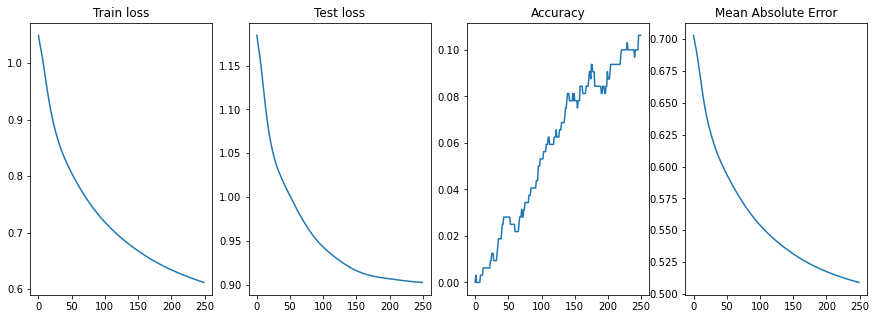

In [94]:
# Loss vs Epoch
plot_history(history)

## 2. 1D convolutional autoencoder
(Kernel size = 3)

In [16]:
# main “event” very well represented while the overall reconstruction is very smooth 

input_window = Input(shape=(window_length,1))
x = Conv1D(16, 3, activation="tanh", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(2, padding="same")(x) # 5 dims
x = Conv1D(1, 3, activation="tanh", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
encoded = MaxPooling1D(2, padding="same")(x) # 3 dims
encoder = Model(input_window, encoded)

# 3 dimensions in the encoded layer

x = Conv1D(1, 3, activation="tanh", padding="same")(encoded) # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 6 dims
x = Conv1D(16, 2, activation='tanh')(x) # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 10 dims
decoded = Conv1D(1, 3, activation='linear', padding='same')(x) # 10 dims
conv_autoencoder = Model(input_window, decoded)
conv_autoencoder.summary()

conv_autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics=['acc','mae'])
history = conv_autoencoder.fit(training_set_scaled, training_set_scaled,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_split = 0.2)

decoded_stocks = conv_autoencoder.predict(test)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 650, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 650, 16)           64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 325, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 325, 1)            49        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 163, 1)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 163, 1)            4         
_________________________________________________________________
up_sampling1d (UpSampling1D) (None, 326, 1)            0   

Epoch 41/500
1/1 [==============================] - 0s 146ms/step - loss: 0.0379 - acc: 0.0084 - mae: 0.1542 - val_loss: 0.0324 - val_acc: 0.0053 - val_mae: 0.1401
Epoch 42/500
1/1 [==============================] - 0s 173ms/step - loss: 0.0371 - acc: 0.0086 - mae: 0.1526 - val_loss: 0.0316 - val_acc: 0.0053 - val_mae: 0.1384
Epoch 43/500
1/1 [==============================] - 0s 158ms/step - loss: 0.0364 - acc: 0.0087 - mae: 0.1511 - val_loss: 0.0309 - val_acc: 0.0053 - val_mae: 0.1370
Epoch 44/500
1/1 [==============================] - 0s 187ms/step - loss: 0.0356 - acc: 0.0089 - mae: 0.1497 - val_loss: 0.0303 - val_acc: 0.0053 - val_mae: 0.1357
Epoch 45/500
1/1 [==============================] - 0s 157ms/step - loss: 0.0350 - acc: 0.0091 - mae: 0.1484 - val_loss: 0.0298 - val_acc: 0.0054 - val_mae: 0.1346
Epoch 46/500
1/1 [==============================] - 0s 171ms/step - loss: 0.0344 - acc: 0.0092 - mae: 0.1474 - val_loss: 0.0294 - val_acc: 0.0054 - val_mae: 0.1339
Epoch 47/500
1/1

Epoch 91/500
1/1 [==============================] - 0s 179ms/step - loss: 0.0327 - acc: 0.0103 - mae: 0.1444 - val_loss: 0.0284 - val_acc: 0.0063 - val_mae: 0.1323
Epoch 92/500
1/1 [==============================] - 0s 196ms/step - loss: 0.0327 - acc: 0.0103 - mae: 0.1443 - val_loss: 0.0284 - val_acc: 0.0063 - val_mae: 0.1323
Epoch 93/500
1/1 [==============================] - 0s 146ms/step - loss: 0.0327 - acc: 0.0104 - mae: 0.1443 - val_loss: 0.0284 - val_acc: 0.0063 - val_mae: 0.1323
Epoch 94/500
1/1 [==============================] - 0s 155ms/step - loss: 0.0327 - acc: 0.0104 - mae: 0.1443 - val_loss: 0.0284 - val_acc: 0.0063 - val_mae: 0.1323
Epoch 95/500
1/1 [==============================] - 0s 171ms/step - loss: 0.0327 - acc: 0.0104 - mae: 0.1443 - val_loss: 0.0284 - val_acc: 0.0064 - val_mae: 0.1323
Epoch 96/500
1/1 [==============================] - 0s 162ms/step - loss: 0.0327 - acc: 0.0104 - mae: 0.1443 - val_loss: 0.0284 - val_acc: 0.0064 - val_mae: 0.1323
Epoch 97/500
1/1

Epoch 141/500
1/1 [==============================] - 0s 154ms/step - loss: 0.0319 - acc: 0.0107 - mae: 0.1425 - val_loss: 0.0279 - val_acc: 0.0064 - val_mae: 0.1311
Epoch 142/500
1/1 [==============================] - 0s 181ms/step - loss: 0.0319 - acc: 0.0107 - mae: 0.1425 - val_loss: 0.0279 - val_acc: 0.0064 - val_mae: 0.1311
Epoch 143/500
1/1 [==============================] - 0s 147ms/step - loss: 0.0319 - acc: 0.0107 - mae: 0.1424 - val_loss: 0.0279 - val_acc: 0.0064 - val_mae: 0.1310
Epoch 144/500
1/1 [==============================] - 0s 138ms/step - loss: 0.0318 - acc: 0.0107 - mae: 0.1424 - val_loss: 0.0278 - val_acc: 0.0064 - val_mae: 0.1310
Epoch 145/500
1/1 [==============================] - 0s 122ms/step - loss: 0.0318 - acc: 0.0107 - mae: 0.1424 - val_loss: 0.0278 - val_acc: 0.0065 - val_mae: 0.1310
Epoch 146/500
1/1 [==============================] - 0s 128ms/step - loss: 0.0318 - acc: 0.0107 - mae: 0.1423 - val_loss: 0.0278 - val_acc: 0.0065 - val_mae: 0.1309
Epoch 147/

Epoch 191/500
1/1 [==============================] - 0s 136ms/step - loss: 0.0309 - acc: 0.0110 - mae: 0.1402 - val_loss: 0.0273 - val_acc: 0.0070 - val_mae: 0.1296
Epoch 192/500
1/1 [==============================] - 0s 164ms/step - loss: 0.0308 - acc: 0.0110 - mae: 0.1401 - val_loss: 0.0273 - val_acc: 0.0070 - val_mae: 0.1295
Epoch 193/500
1/1 [==============================] - 0s 142ms/step - loss: 0.0308 - acc: 0.0110 - mae: 0.1401 - val_loss: 0.0272 - val_acc: 0.0070 - val_mae: 0.1295
Epoch 194/500
1/1 [==============================] - 0s 136ms/step - loss: 0.0308 - acc: 0.0110 - mae: 0.1400 - val_loss: 0.0272 - val_acc: 0.0070 - val_mae: 0.1295
Epoch 195/500
1/1 [==============================] - 0s 163ms/step - loss: 0.0308 - acc: 0.0110 - mae: 0.1399 - val_loss: 0.0272 - val_acc: 0.0070 - val_mae: 0.1294
Epoch 196/500
1/1 [==============================] - 0s 196ms/step - loss: 0.0308 - acc: 0.0110 - mae: 0.1399 - val_loss: 0.0272 - val_acc: 0.0070 - val_mae: 0.1294
Epoch 197/

Epoch 290/500
1/1 [==============================] - 0s 177ms/step - loss: 0.0283 - acc: 0.0115 - mae: 0.1339 - val_loss: 0.0258 - val_acc: 0.0076 - val_mae: 0.1259
Epoch 291/500
1/1 [==============================] - 0s 185ms/step - loss: 0.0283 - acc: 0.0115 - mae: 0.1339 - val_loss: 0.0258 - val_acc: 0.0077 - val_mae: 0.1259
Epoch 292/500
1/1 [==============================] - 0s 201ms/step - loss: 0.0283 - acc: 0.0115 - mae: 0.1338 - val_loss: 0.0258 - val_acc: 0.0077 - val_mae: 0.1259
Epoch 293/500
1/1 [==============================] - 0s 244ms/step - loss: 0.0282 - acc: 0.0115 - mae: 0.1337 - val_loss: 0.0258 - val_acc: 0.0077 - val_mae: 0.1258
Epoch 294/500
1/1 [==============================] - 0s 144ms/step - loss: 0.0282 - acc: 0.0115 - mae: 0.1337 - val_loss: 0.0258 - val_acc: 0.0077 - val_mae: 0.1258
Epoch 295/500
1/1 [==============================] - 0s 179ms/step - loss: 0.0282 - acc: 0.0115 - mae: 0.1336 - val_loss: 0.0258 - val_acc: 0.0077 - val_mae: 0.1257
Epoch 296/

Epoch 340/500
1/1 [==============================] - 0s 177ms/step - loss: 0.0271 - acc: 0.0116 - mae: 0.1306 - val_loss: 0.0251 - val_acc: 0.0080 - val_mae: 0.1242
Epoch 341/500
1/1 [==============================] - 0s 164ms/step - loss: 0.0270 - acc: 0.0116 - mae: 0.1305 - val_loss: 0.0251 - val_acc: 0.0080 - val_mae: 0.1241
Epoch 342/500
1/1 [==============================] - 0s 145ms/step - loss: 0.0270 - acc: 0.0116 - mae: 0.1304 - val_loss: 0.0251 - val_acc: 0.0080 - val_mae: 0.1241
Epoch 343/500
1/1 [==============================] - 0s 155ms/step - loss: 0.0270 - acc: 0.0116 - mae: 0.1304 - val_loss: 0.0251 - val_acc: 0.0080 - val_mae: 0.1241
Epoch 344/500
1/1 [==============================] - 0s 149ms/step - loss: 0.0270 - acc: 0.0116 - mae: 0.1303 - val_loss: 0.0251 - val_acc: 0.0080 - val_mae: 0.1240
Epoch 345/500
1/1 [==============================] - 0s 163ms/step - loss: 0.0269 - acc: 0.0116 - mae: 0.1303 - val_loss: 0.0251 - val_acc: 0.0080 - val_mae: 0.1240
Epoch 346/

Epoch 390/500
1/1 [==============================] - 0s 181ms/step - loss: 0.0263 - acc: 0.0117 - mae: 0.1283 - val_loss: 0.0247 - val_acc: 0.0081 - val_mae: 0.1230
Epoch 391/500
1/1 [==============================] - 0s 146ms/step - loss: 0.0263 - acc: 0.0117 - mae: 0.1283 - val_loss: 0.0247 - val_acc: 0.0081 - val_mae: 0.1230
Epoch 392/500
1/1 [==============================] - 0s 128ms/step - loss: 0.0263 - acc: 0.0117 - mae: 0.1282 - val_loss: 0.0247 - val_acc: 0.0081 - val_mae: 0.1230
Epoch 393/500
1/1 [==============================] - 0s 175ms/step - loss: 0.0262 - acc: 0.0117 - mae: 0.1282 - val_loss: 0.0247 - val_acc: 0.0081 - val_mae: 0.1230
Epoch 394/500
1/1 [==============================] - 0s 182ms/step - loss: 0.0262 - acc: 0.0117 - mae: 0.1282 - val_loss: 0.0247 - val_acc: 0.0081 - val_mae: 0.1230
Epoch 395/500
1/1 [==============================] - 0s 166ms/step - loss: 0.0262 - acc: 0.0117 - mae: 0.1282 - val_loss: 0.0247 - val_acc: 0.0081 - val_mae: 0.1229
Epoch 396/

Epoch 440/500
1/1 [==============================] - 0s 122ms/step - loss: 0.0260 - acc: 0.0118 - mae: 0.1274 - val_loss: 0.0245 - val_acc: 0.0081 - val_mae: 0.1226
Epoch 441/500
1/1 [==============================] - 0s 135ms/step - loss: 0.0260 - acc: 0.0118 - mae: 0.1274 - val_loss: 0.0245 - val_acc: 0.0081 - val_mae: 0.1226
Epoch 442/500
1/1 [==============================] - 0s 168ms/step - loss: 0.0260 - acc: 0.0118 - mae: 0.1274 - val_loss: 0.0245 - val_acc: 0.0081 - val_mae: 0.1225
Epoch 443/500
1/1 [==============================] - 0s 167ms/step - loss: 0.0260 - acc: 0.0118 - mae: 0.1274 - val_loss: 0.0245 - val_acc: 0.0081 - val_mae: 0.1225
Epoch 444/500
1/1 [==============================] - 0s 151ms/step - loss: 0.0260 - acc: 0.0118 - mae: 0.1274 - val_loss: 0.0245 - val_acc: 0.0081 - val_mae: 0.1225
Epoch 445/500
1/1 [==============================] - 0s 142ms/step - loss: 0.0260 - acc: 0.0118 - mae: 0.1274 - val_loss: 0.0245 - val_acc: 0.0081 - val_mae: 0.1225
Epoch 446/

Epoch 490/500
1/1 [==============================] - 0s 155ms/step - loss: 0.0259 - acc: 0.0118 - mae: 0.1272 - val_loss: 0.0245 - val_acc: 0.0082 - val_mae: 0.1224
Epoch 491/500
1/1 [==============================] - 0s 176ms/step - loss: 0.0259 - acc: 0.0118 - mae: 0.1271 - val_loss: 0.0245 - val_acc: 0.0081 - val_mae: 0.1224
Epoch 492/500
1/1 [==============================] - 0s 203ms/step - loss: 0.0259 - acc: 0.0118 - mae: 0.1271 - val_loss: 0.0245 - val_acc: 0.0081 - val_mae: 0.1224
Epoch 493/500
1/1 [==============================] - 0s 150ms/step - loss: 0.0259 - acc: 0.0118 - mae: 0.1271 - val_loss: 0.0245 - val_acc: 0.0081 - val_mae: 0.1223
Epoch 494/500
1/1 [==============================] - 0s 167ms/step - loss: 0.0259 - acc: 0.0118 - mae: 0.1271 - val_loss: 0.0245 - val_acc: 0.0082 - val_mae: 0.1223
Epoch 495/500
1/1 [==============================] - 0s 157ms/step - loss: 0.0259 - acc: 0.0118 - mae: 0.1271 - val_loss: 0.0245 - val_acc: 0.0082 - val_mae: 0.1223
Epoch 496/

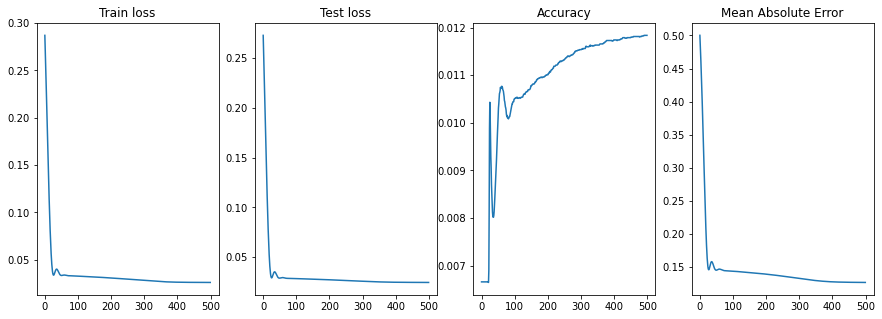

In [17]:
plot_history(history)

In [18]:
#pd.DataFrame(encoder.predict(test_set_scaled))

## 3. Multiple Layers w/ L1 Regularization

In [23]:
import tensorflow as tf

def model(optimizer = "Adam", score = "acc"):
    #Input Layer
    input_layer = Input(shape =(df.shape[1], ))
  
    #Encode
    encoded = Dense(100, activation ='tanh',
                    activity_regularizer = regularizers.l1(10e-5))(input_layer)
    encoded = Dense(50, activation ='tanh',
                    activity_regularizer = regularizers.l1(10e-5))(encoded)
    encoded = Dense(25, activation ='tanh',
                    activity_regularizer = regularizers.l1(10e-5))(encoded)
    encoded = Dense(12, activation ='tanh',
                    activity_regularizer = regularizers.l1(10e-5))(encoded)
    encoded = Dense(6, activation ='relu')(encoded)

    #Decoder
    decoded = Dense(12, activation ='linear')(encoded)
    decoded = Dense(25, activation ='linear')(decoded)
    decoded = Dense(50, activation ='linear')(decoded)
    decoded = Dense(100, activation ='linear')(decoded)

    #Output
    output_layer = Dense(df.shape[1], activation ='linear')(decoded)

    #Parameters
    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer =optimizer, loss =tf.keras.losses.MeanSquaredError(), metrics = ['acc','mae'])
    
    return autoencoder

In [24]:
# Training the Auto-encoder network
output = model().fit(training_set_scaled, training_set_scaled,
                batch_size = 16, epochs = 100, 
                shuffle = True, validation_split = 0.2)
output

Epoch 1/100
8/8 [==============================] - 2s 95ms/step - loss: 0.3207 - acc: 0.0053 - mae: 0.5152 - val_loss: 0.2258 - val_acc: 0.0000e+00 - val_mae: 0.4158
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.1805 - acc: 0.0128 - mae: 0.3451 - val_loss: 0.0771 - val_acc: 0.0000e+00 - val_mae: 0.2023
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0645 - acc: 0.0000e+00 - mae: 0.1739 - val_loss: 0.0356 - val_acc: 0.0000e+00 - val_mae: 0.1077
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0410 - acc: 0.0000e+00 - mae: 0.1231 - val_loss: 0.0335 - val_acc: 0.0000e+00 - val_mae: 0.1009
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0402 - acc: 0.0183 - mae: 0.1194 - val_loss: 0.0293 - val_acc: 0.0000e+00 - val_mae: 0.0854
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0341 - acc: 0.0149 - mae: 0.1031 - val_loss: 0.0287 - val_acc: 0.0000e+00 - val_mae: 0.0863


8/8 [==============================] - 0s 9ms/step - loss: 0.0160 - acc: 0.0215 - mae: 0.0806 - val_loss: 0.0161 - val_acc: 0.0000e+00 - val_mae: 0.0769
Epoch 100/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0162 - acc: 0.0251 - mae: 0.0819 - val_loss: 0.0167 - val_acc: 0.0000e+00 - val_mae: 0.0796


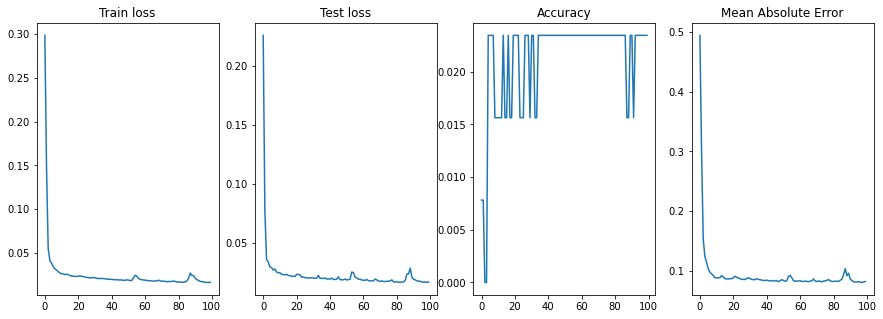

In [25]:
plot_history(output)

## Hyper-parameter Tuning

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

model_regressor = KerasRegressor(model, verbose=1, batch_size=10, epochs=10)
#define the grid search parameters
#dimensions = []
#dropout = []
batch_size = [10,20]
loss = ['mean_squared_error']
optimizer = ['Adam', 'SGD', 'RMSprop']
epochs = [10, 15]
scoring = ['acc']

param_grid = dict(optimizer=optimizer,score = scoring)
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5",save_best_only=True)

grid = GridSearchCV(estimator=model_regressor, param_grid=param_grid, 
                    n_jobs=1, cv = 3)

## Error
grid_result = grid.fit(df,df, callbacks=[monitor,checkpointer]) # X, y?

grid_best_parameters = grid_result.best_params_
grid_best_accuracy = grid_result.best_score_

Epoch 1/10
14/14 [==============================] - 2s 3ms/step - loss: 0.0063 - acc: 0.0021 - mae: 0.0559 
Epoch 2/10
14/14 [==============================] - 0s 4ms/step - loss: 0.0032 - acc: 0.0033 - mae: 0.0332
Epoch 3/10
14/14 [==============================] - 0s 3ms/step - loss: 0.0027 - acc: 0.0036 - mae: 0.0282
Epoch 4/10
14/14 [==============================] - 0s 3ms/step - loss: 0.0025 - acc: 0.0270 - mae: 0.0270
Epoch 5/10
14/14 [==============================] - 0s 3ms/step - loss: 0.0025 - acc: 0.0220 - mae: 0.0270
Epoch 6/10
14/14 [==============================] - 0s 3ms/step - loss: 0.0023 - acc: 0.0140 - mae: 0.0256
Epoch 7/10
14/14 [==============================] - 0s 4ms/step - loss: 0.0022 - acc: 0.0398 - mae: 0.0259
Epoch 8/10
14/14 [==============================] - 0s 4ms/step - loss: 0.0022 - acc: 0.0160 - mae: 0.0258
Epoch 9/10
14/14 [==============================] - 0s 3ms/step - loss: 0.0022 - acc: 0.0515 - mae: 0.0260
Epoch 10/10
7/7 [===================

Epoch 7/10
14/14 [==============================] - 0s 5ms/step - loss: 0.0025 - acc: 0.0204 - mae: 0.0278
Epoch 8/10
14/14 [==============================] - 0s 5ms/step - loss: 0.0024 - acc: 0.0132 - mae: 0.0274
Epoch 9/10
14/14 [==============================] - 0s 4ms/step - loss: 0.0024 - acc: 0.0269 - mae: 0.0272
Epoch 10/10
7/7 [==============================] - 1s 2ms/step - loss: 0.0022 - acc: 0.0303 - mae: 0.0251
Epoch 1/10
14/14 [==============================] - 1s 2ms/step - loss: 0.0065 - acc: 0.0000e+00 - mae: 0.0582
Epoch 2/10
14/14 [==============================] - 0s 3ms/step - loss: 0.0066 - acc: 0.0000e+00 - mae: 0.0582
Epoch 3/10
14/14 [==============================] - 0s 3ms/step - loss: 0.0066 - acc: 0.0000e+00 - mae: 0.0588
Epoch 4/10
14/14 [==============================] - 0s 2ms/step - loss: 0.0065 - acc: 0.0000e+00 - mae: 0.0579
Epoch 5/10
14/14 [==============================] - 0s 3ms/step - loss: 0.0067 - acc: 0.0000e+00 - mae: 0.0592
Epoch 6/10
14/14 [

Epoch 2/10
14/14 [==============================] - 0s 3ms/step - loss: 0.0075 - acc: 0.0000e+00 - mae: 0.0601
Epoch 3/10
14/14 [==============================] - 0s 6ms/step - loss: 0.0079 - acc: 0.0000e+00 - mae: 0.0623
Epoch 4/10
14/14 [==============================] - 0s 3ms/step - loss: 0.0074 - acc: 0.0000e+00 - mae: 0.0601
Epoch 5/10
14/14 [==============================] - 0s 5ms/step - loss: 0.0075 - acc: 0.0000e+00 - mae: 0.0603
Epoch 6/10
14/14 [==============================] - 0s 4ms/step - loss: 0.0077 - acc: 0.0000e+00 - mae: 0.0613
Epoch 7/10
14/14 [==============================] - 0s 3ms/step - loss: 0.0078 - acc: 0.0000e+00 - mae: 0.0623
Epoch 8/10
14/14 [==============================] - 0s 4ms/step - loss: 0.0073 - acc: 0.0000e+00 - mae: 0.0597
Epoch 9/10
14/14 [==============================] - 0s 3ms/step - loss: 0.0079 - acc: 0.0000e+00 - mae: 0.0627
Epoch 10/10
7/7 [==============================] - 1s 2ms/step - loss: 0.0066 - acc: 0.0152 - mae: 0.0576
Epoch 

In [31]:
grid_best_parameters

{'optimizer': 'Adam', 'score': 'acc'}

In [32]:
grid_best_accuracy

-0.0025763385153065124

In [28]:
random_search = RandomizedSearchCV(estimator=model_regressor, param_distributions=param_grid, n_iter=100)
random_search.fit(training_set_scaled, training_set_scaled)

random_best_parameters = grid_result.best_params_
random_best_accuracy = grid_result.best_score_

/Users/anjalichauhan/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 3 is smaller than n_iter=100. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Epoch 1/10
13/13 [==============================] - 1s 3ms/step - loss: 0.2643 - acc: 0.0000e+00 - mae: 0.4479
Epoch 2/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0490 - acc: 0.0000e+00 - mae: 0.1423
Epoch 3/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0326 - acc: 0.0011 - mae: 0.1055
Epoch 4/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0309 - acc: 0.0129 - mae: 0.0985
Epoch 5/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0278 - acc: 0.0267 - mae: 0.0913
Epoch 6/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0269 - acc: 0.0207 - mae: 0.0909
Epoch 7/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0246 - acc: 0.0242 - mae: 0.0877
Epoch 8/10
13/13 [==============================] - 0s 4ms/step - loss: 0.0242 - acc: 0.0243 - mae: 0.0879
Epoch 9/10
13/13 [==============================] - 0s 3ms/step - loss: 0.0221 - acc: 0.0158 - mae: 0.0838
Epoch 10/10
4/4 [============

4/4 [==============================] - 1s 3ms/step - loss: 0.3110 - acc: 0.0000e+00 - mae: 0.5129
Epoch 1/10
13/13 [==============================] - 2s 3ms/step - loss: 0.3133 - acc: 0.0000e+00 - mae: 0.5202
Epoch 2/10
13/13 [==============================] - 0s 3ms/step - loss: 0.3151 - acc: 0.0048 - mae: 0.5220
Epoch 3/10
13/13 [==============================] - 0s 3ms/step - loss: 0.3148 - acc: 0.0039 - mae: 0.5235
Epoch 4/10
13/13 [==============================] - 0s 3ms/step - loss: 0.3129 - acc: 0.0161 - mae: 0.5211
Epoch 5/10
13/13 [==============================] - 0s 4ms/step - loss: 0.3098 - acc: 0.0219 - mae: 0.5198
Epoch 6/10
13/13 [==============================] - 0s 3ms/step - loss: 0.3105 - acc: 0.0000e+00 - mae: 0.5194
Epoch 7/10
13/13 [==============================] - 0s 3ms/step - loss: 0.3125 - acc: 0.0000e+00 - mae: 0.5214
Epoch 8/10
13/13 [==============================] - 0s 4ms/step - loss: 0.3172 - acc: 0.0000e+00 - mae: 0.5256
Epoch 9/10
13/13 [============

In [29]:
random_best_parameters

{'optimizer': 'Adam', 'score': 'acc'}

In [34]:
random_best_accuracy

-0.0025763385153065124

## Notes

- Code's working fine now, there are about 3 different autoencoders here, Simple, Convolutional and one with multiple layers and regularization.
- Performed hyp tuning on the last autoencoder model with multiple layers
- The only thing we need to do is add the parameters in model() and param_grid. At the moment, I've only tried optimizer and score. 
- Makes those changes here: 
    - def model(optimizer = "Adam", score = "acc", epoch = '', batch_size= '',....)
    - param_grid = dict(optimizer=optimizer,score = scoring, epoch = ....)
- Parameters we need to add: no. of Dimensions of our dataframe, loss function, epochs, batch_size, dropout